# Nearest Centroid Classification on a Trapped Ion Quantum Computer

**Paper**: Johri et al. (2020) - [arXiv:2012.04145v2](https://arxiv.org/abs/2012.04145)

**Authors**: Sonika Johri, Shantanu Debnath, Avinash Mocherla, Alexandros Singh, Anupam Prakash, Jungsang Kim, Iordanis Kerenidis

This notebook provides a pedagogical walkthrough of the quantum nearest centroid classifier, explains the key quantum circuits, and reproduces the paper's experimental results.

## Table of Contents

1. Overview
2. Quantum Data Encoding
3. The RBS Gate
4. Distance Estimation Circuit
5. Nearest Centroid Algorithm
6. Experiments

---
## 1. Overview

### The Problem

**Nearest Centroid Classification** is a simple but effective algorithm:
1. Compute the centroid (mean) of each class in the training data
2. For a new point, find the closest centroid
3. Assign the class of that centroid

The key operation is computing **distances** between vectors.

### The Quantum Advantage

For d-dimensional data with k classes:
- **Classical**: O(kd) time per classification
- **Quantum**: O(k log d) time per classification

The speedup comes from encoding d-dimensional vectors into log(d) depth circuits using **amplitude encoding**.

### Key Components

1. **Data Loader**: Encodes classical vectors into quantum states
2. **RBS Gate**: The building block for data loading (Reconfigurable Beam Splitter)
3. **Distance Estimation**: Quantum circuit to estimate Euclidean distance
4. **Classification**: Find minimum distance across all centroids

---
## 2. Quantum Data Encoding

### Amplitude Encoding

A classical vector x = (x1, x2, ..., xd) is encoded as a quantum state where each amplitude corresponds to a component of the vector.

The paper uses **unary encoding** where basis states are:
- First basis: photon in mode 1
- Second basis: photon in mode 2
- And so on...

This requires d modes (qubits/photonic modes) but only **1 photon**.

### Why Unary?

| Encoding | Qubits | Photons | Circuit Depth |
|----------|--------|---------|---------------|
| Binary   | log2(d) | Multiple | O(d) |
| **Unary** | d | **1** | **O(log d)** |

The key advantage: **logarithmic depth** circuits, which is crucial for noisy hardware.

### The Loading Process

Start with a single photon in mode 0, then apply a tree of RBS gates to distribute the amplitude.

In [1]:
# Visualize unary encoding
import matplotlib.pyplot as plt
import numpy as np

# Example: encode vector [0.5, 0.5, 0.5, 0.5] (normalized)
x = np.array([0.5, 0.5, 0.5, 0.5])
x_norm = x / np.linalg.norm(x)  # Must be unit vector for amplitude encoding

print("Classical vector x:", x)
print("Normalized (unit) vector:", x_norm)
print("")
print("Quantum state:")
for i, amp in enumerate(x_norm):
    basis = "0" * i + "1" + "0" * (len(x) - i - 1)
    print(f"  {amp:.3f} * |{basis}>")

Classical vector x: [0.5 0.5 0.5 0.5]
Normalized (unit) vector: [0.5 0.5 0.5 0.5]

Quantum state:
  0.500 * |1000>
  0.500 * |0100>
  0.500 * |0010>
  0.500 * |0001>


---
## 3. The RBS Gate

### Definition

The **Reconfigurable Beam Splitter (RBS)** gate acts on two modes. Its matrix is:

```
RBS(theta) = [ cos(theta)   sin(theta)  ]
             [ -sin(theta)  cos(theta)  ]
```

This is a rotation in the 2D subspace of two modes.

### Physical Interpretation

- **Photonic**: A beam splitter with tunable reflectivity
- **Ion trap**: Equivalent to Molmer-Sorensen gate + single-qubit rotations
- **Effect**: Redistributes amplitude between two modes

### Example

A 50/50 beam splitter (theta = pi/4) creates equal superposition from a single-mode input.

In [2]:
def RBS(theta):
    """RBS gate matrix."""
    return np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])


# Demonstrate RBS gate
theta = np.pi / 4  # 45 degrees
input_state = np.array([1, 0])  # Photon in first mode
output_state = RBS(theta) @ input_state

print("RBS(pi/4) on input |1,0>:")
print("  Input:  |1,0>")
print(f"  Output: {output_state[0]:.3f}*|1,0> + {output_state[1]:.3f}*|0,1>")
print("         = (1/sqrt(2))*|1,0> + (1/sqrt(2))*|0,1>")

RBS(pi/4) on input |1,0>:
  Input:  |1,0>
  Output: 0.707*|1,0> + -0.707*|0,1>
         = (1/sqrt(2))*|1,0> + (1/sqrt(2))*|0,1>


### Computing RBS Angles

To encode a vector x, we need to compute the correct angles. The paper uses a **binary tree** structure:

```
          theta_1
         /       \
      theta_2   theta_3
       /  \      /  \
      x1  x2   x3  x4
```

The angle at each node is computed from the partial norms of the left and right subtrees.

In [3]:
def compute_angles(x):
    """Compute RBS angles for encoding vector x (simplified for power-of-2 dimensions)."""
    x = np.array(x)
    n = len(x)
    if n == 1:
        return []

    mid = n // 2
    left_norm = np.linalg.norm(x[:mid])
    right_norm = np.linalg.norm(x[mid:])

    if left_norm < 1e-10:
        theta = np.pi / 2
    else:
        theta = np.arctan(right_norm / left_norm)

    # Recursively compute angles for subtrees
    left_angles = compute_angles(x[:mid] / left_norm if left_norm > 1e-10 else x[:mid])
    right_angles = compute_angles(
        x[mid:] / right_norm if right_norm > 1e-10 else x[mid:]
    )

    return [theta] + left_angles + right_angles


# Example
x = np.array([0.5, 0.5, 0.5, 0.5])
x_norm = x / np.linalg.norm(x)
angles = compute_angles(x_norm)

print("Vector:", x_norm)
print("RBS angles (radians):", [round(a, 4) for a in angles])
print("RBS angles (degrees):", [round(np.degrees(a), 1) for a in angles])

Vector: [0.5 0.5 0.5 0.5]
RBS angles (radians): [np.float64(0.7854), np.float64(0.7854), np.float64(0.7854)]
RBS angles (degrees): [np.float64(45.0), np.float64(45.0), np.float64(45.0)]


---
## 4. Distance Estimation Circuit

### The Key Insight

Euclidean distance can be computed from inner products:

```
dist(x,y)^2 = norm(x)^2 + norm(y)^2 - 2 * dot(x, y)
```

For normalized vectors (norm = 1):

```
dist(x,y)^2 = 2 * (1 - dot(x, y))
```

So we only need to estimate the **inner product** c_xy = dot(x, y).

### The Circuit

```
|0> --- [Load x] --- [Load y inverse] --- Measure
```

1. **Load x**: Apply RBS tree to encode x
2. **Load y inverse**: Apply inverse RBS tree for y
3. **Measure**: Probability of returning to initial state

### Why This Works

The probability of finding the photon back in mode 0 equals the squared inner product:

```
P(mode 0) = dot(x, y)^2
```

In [4]:
# Demonstrate inner product estimation
def inner_product_classical(x, y):
    """Classical inner product."""
    return np.dot(x, y)


def inner_product_quantum_simulation(x, y, n_shots=1000):
    """Simulate quantum inner product estimation."""
    # In ideal simulation, P(mode 0) = dot(x,y)^2
    c_xy_squared = np.dot(x, y) ** 2

    # Simulate shot noise
    counts = np.random.binomial(n_shots, c_xy_squared)
    estimated_c_squared = counts / n_shots

    return np.sqrt(estimated_c_squared)


# Example: two similar vectors
x = np.array([0.8, 0.6, 0.0, 0.0])
y = np.array([0.7, 0.7, 0.1, 0.0])
x = x / np.linalg.norm(x)
y = y / np.linalg.norm(y)

c_classical = inner_product_classical(x, y)
c_quantum = inner_product_quantum_simulation(x, y, n_shots=1000)

print("Vector x:", x)
print("Vector y:", y)
print("")
print(f"Classical inner product: {c_classical:.4f}")
print(f"Quantum estimate (1000 shots): {c_quantum:.4f}")
print("")
print(f"Euclidean distance: {np.sqrt(2 * (1 - c_classical)):.4f}")

Vector x: [0.8 0.6 0.  0. ]
Vector y: [0.70352647 0.70352647 0.10050378 0.        ]

Classical inner product: 0.9849
Quantum estimate (1000 shots): 0.9844

Euclidean distance: 0.1736


### Circuit Diagram (Simplified)

For 4-dimensional vectors:

```
Mode 0: --*---------------*------------- M
          |               |
Mode 1: --RBS(t1)--*------RBS(-p1)--*--- M
                   |                |
Mode 2: ----------RBS(t2)----------RBS(-p2) M
                   |                |
Mode 3: ----------RBS(t3)----------RBS(-p3) M
         
         |-- Load x --|  |-- Load y inv --|
```

- t values encode vector x
- p values encode vector y (applied in reverse)
- Measure probability of photon in Mode 0

---
## 5. Nearest Centroid Algorithm

### Classical Algorithm

The classical nearest centroid algorithm computes distances from a test point to all centroids and returns the class of the nearest one.

### Quantum Algorithm

The quantum version replaces the distance calculation with the quantum inner product estimation circuit. For each centroid, we run the circuit multiple times (n_shots) to estimate the squared inner product, then convert to distance.

### Error Mitigation

On real hardware, noise can cause the photon to end up in invalid states. The paper uses **post-selection**:

- Valid states: exactly one photon in one mode (unary basis)
- Invalid states: multiple photons, no photons, etc.
- Post-selection: discard invalid measurement outcomes

This works when the error rate is low enough that most shots are valid.

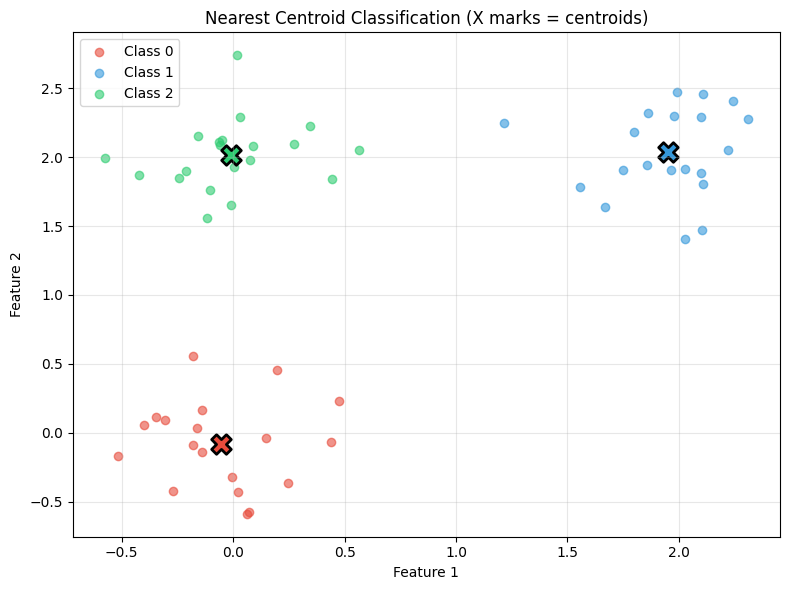

Centroids:
  Class 0: [-0.05, -0.08]
  Class 1: [1.95, 2.03]
  Class 2: [-0.01, 2.01]


In [5]:
# Demonstrate nearest centroid classification
from sklearn.neighbors import NearestCentroid

# Create simple 2D dataset
np.random.seed(42)
n_per_class = 20

class0 = np.random.randn(n_per_class, 2) * 0.3 + [0, 0]
class1 = np.random.randn(n_per_class, 2) * 0.3 + [2, 2]
class2 = np.random.randn(n_per_class, 2) * 0.3 + [0, 2]

X = np.vstack([class0, class1, class2])
y = np.array([0] * n_per_class + [1] * n_per_class + [2] * n_per_class)

# Fit classical nearest centroid
clf = NearestCentroid()
clf.fit(X, y)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["#e74c3c", "#3498db", "#2ecc71"]

for i in range(3):
    mask = y == i
    ax.scatter(X[mask, 0], X[mask, 1], c=colors[i], label="Class " + str(i), alpha=0.6)
    ax.scatter(
        clf.centroids_[i, 0],
        clf.centroids_[i, 1],
        c=colors[i],
        marker="X",
        s=200,
        edgecolors="black",
        linewidths=2,
    )

ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Nearest Centroid Classification (X marks = centroids)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Centroids:")
for i, c in enumerate(clf.centroids_):
    print(f"  Class {i}: [{c[0]:.2f}, {c[1]:.2f}]")

---
## 6. Experiments

Now we reproduce the paper's experiments using the `lib.runner` module.

### Experimental Setup

| Parameter | Description |
|-----------|-------------|
| Nq | Number of qubits (dimensions after PCA) |
| Nc | Number of classes |
| Ns | Number of shots (circuit repetitions) |
| n | Total samples used |

### Datasets

1. **Synthetic**: Clustered Gaussian data (n=10 per cluster)
2. **IRIS**: 3 classes, 4 features, 150 samples
3. **MNIST**: 10 digit classes, 784 to 8 PCA dimensions

In [6]:
# Setup for experiments
from pathlib import Path

import torchvision
import torchvision.transforms as transforms
from lib.runner import run_subset_experiment, set_seed
from lib.synthetic_data import generate_synthetic_data
from sklearn import datasets

set_seed(123)
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)


def plot_error_bars(results_list, title, save_path=None):
    """Plot classification error from runner results."""
    fig, ax = plt.subplots(figsize=(10, 5))

    labels = []
    for r in results_list:
        nq = r["n_components"]
        nc = len(r["classes"])
        n = r["n_used"]
        labels.append("Nq=" + str(nq) + "\nNc=" + str(nc) + "\nn=" + str(n))

    x = np.arange(len(results_list))
    width = 0.25

    classical_err = [(1 - r["c_acc_mean"]) * 100 for r in results_list]
    classical_std = [r["c_acc_std"] * 100 for r in results_list]
    cirq_err = [(1 - r["acc_mean"]) * 100 for r in results_list]
    cirq_std = [r["acc_std"] * 100 for r in results_list]
    merlin_err = [(1 - r["ml_acc_mean"]) * 100 for r in results_list]
    merlin_std = [r["ml_acc_std"] * 100 for r in results_list]

    ax.bar(
        x - width,
        classical_err,
        width,
        yerr=classical_std,
        label="Classical",
        color="#2ecc71",
        capsize=4,
    )
    ax.bar(
        x,
        cirq_err,
        width,
        yerr=cirq_std,
        label="Quantum (Cirq)",
        color="#3498db",
        capsize=4,
    )
    ax.bar(
        x + width,
        merlin_err,
        width,
        yerr=merlin_std,
        label="Quantum (MerLin)",
        color="#e74c3c",
        capsize=4,
    )

    ax.set_ylabel("Classification Error (%)")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    return fig


print("Ready for experiments!")

Ready for experiments!


### 6.1 Synthetic Data (Paper Figure 8)

Synthetic clustered data with:
- k clusters with minimum separation 0.3
- n = 10 points per cluster
- Gaussian variance = 0.05
- Points normalized to unit sphere

In [7]:
synthetic_configs = [
    {"n_clusters": 2, "n_dimensions": 4, "n_shots": 100},
    {"n_clusters": 4, "n_dimensions": 4, "n_shots": 500},
    {"n_clusters": 2, "n_dimensions": 8, "n_shots": 1000},
    {"n_clusters": 4, "n_dimensions": 8, "n_shots": 1000},
]
synthetic_results = []

for cfg in synthetic_configs:
    print(
        "Nq="
        + str(cfg["n_dimensions"])
        + ", Nc="
        + str(cfg["n_clusters"])
        + ", Ns="
        + str(cfg["n_shots"])
    )
    X, y, _ = generate_synthetic_data(
        n_clusters=cfg["n_clusters"],
        n_dimensions=cfg["n_dimensions"],
        n_points_per_cluster=10,
        min_centroid_distance=0.3,
        gaussian_variance=0.05,
        seed=123,
    )

    result = run_subset_experiment(
        X,
        y,
        classes=list(range(cfg["n_clusters"])),
        n_components=cfg["n_dimensions"],
        n_shots=cfg["n_shots"],
        n_repeats=10,
        test_size=0.5,
        run_dir=RESULTS_DIR,
    )
    synthetic_results.append(result)
    print("  Classical: " + str(round(result["c_acc_mean"] * 100, 1)) + "%")
    print("  Cirq:      " + str(round(result["acc_mean"] * 100, 1)) + "%")
    print("  MerLin:    " + str(round(result["ml_acc_mean"] * 100, 1)) + "%")
    print()

Nq=4, Nc=2, Ns=100
  Classical: 100.0%
  Cirq:      100.0%
  MerLin:    99.0%

Nq=4, Nc=4, Ns=500
  Classical: 94.5%
  Cirq:      94.5%
  MerLin:    93.5%

Nq=8, Nc=2, Ns=1000
  Classical: 85.0%
  Cirq:      79.0%
  MerLin:    79.0%

Nq=8, Nc=4, Ns=1000
  Classical: 94.0%
  Cirq:      93.0%
  MerLin:    92.5%



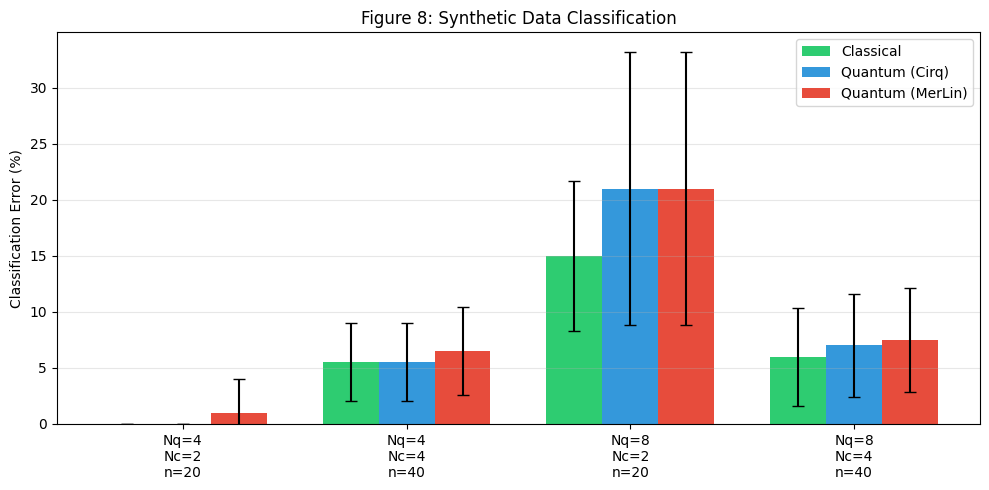

In [8]:
plot_error_bars(
    synthetic_results,
    "Figure 8: Synthetic Data Classification",
    RESULTS_DIR / "fig8_synthetic.png",
)
plt.show()

### 6.2 IRIS Dataset (Paper Figure 9)

Classic ML benchmark:
- 3 flower species (Setosa, Versicolor, Virginica)
- 4 features (sepal/petal dimensions)
- 150 total samples
- No PCA needed (already 4D = 4 qubits)

In [9]:
iris = datasets.load_iris()
iris_results = []

for n_shots in [100, 500, 1000]:
    print("IRIS with Ns=" + str(n_shots) + " shots")
    result = run_subset_experiment(
        iris.data,
        iris.target,
        classes=[0, 1, 2],
        n_components=4,
        n_shots=n_shots,
        n_repeats=10,
        test_size=0.5,
        max_samples=150,
        run_dir=RESULTS_DIR,
    )
    iris_results.append(result)
    print("  Classical: " + str(round(result["c_acc_mean"] * 100, 1)) + "%")
    print("  Cirq:      " + str(round(result["acc_mean"] * 100, 1)) + "%")
    print("  MerLin:    " + str(round(result["ml_acc_mean"] * 100, 1)) + "%")
    print()

IRIS with Ns=100 shots
  Classical: 93.5%
  Cirq:      91.7%
  MerLin:    91.9%

IRIS with Ns=500 shots
  Classical: 93.5%
  Cirq:      91.5%
  MerLin:    91.9%

IRIS with Ns=1000 shots
  Classical: 93.5%
  Cirq:      92.4%
  MerLin:    92.0%



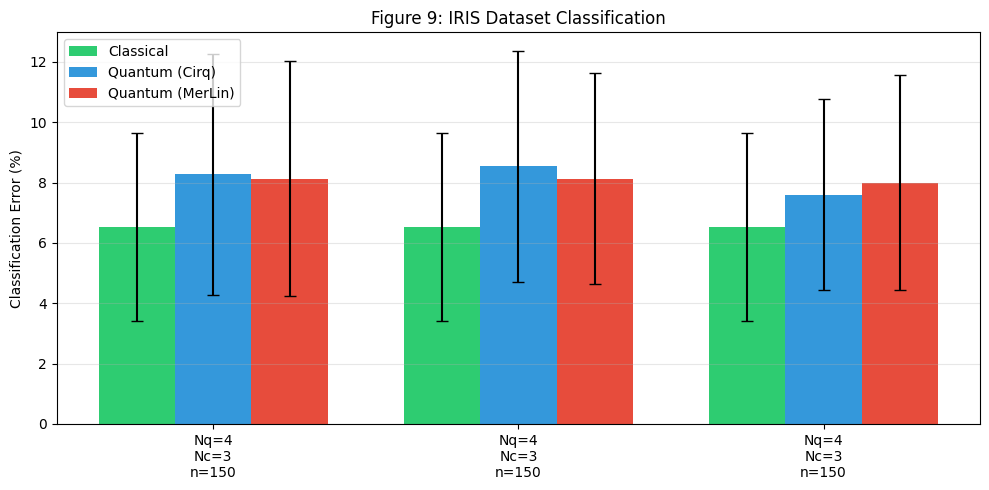

In [10]:
plot_error_bars(
    iris_results, "Figure 9: IRIS Dataset Classification", RESULTS_DIR / "fig9_iris.png"
)
plt.show()

### 6.3 MNIST Dataset (Paper Figure 11)

Handwritten digit classification:
- 10 digit classes (0-9)
- 28x28 = 784 pixels reduced to 8 dimensions via PCA
- Paper uses small controlled subsets (not full 60k images)

In [11]:
print("Loading MNIST...")
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))]
)
mnist = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
X_mnist = mnist.data.numpy().reshape(len(mnist), -1)
y_mnist = mnist.targets.numpy()
print(
    "MNIST loaded: "
    + str(X_mnist.shape[0])
    + " samples, "
    + str(X_mnist.shape[1])
    + " features"
)

Loading MNIST...
MNIST loaded: 60000 samples, 784 features


In [12]:
# Binary classification (fast)
mnist_binary_results = []

for classes in [[0, 1], [2, 7]]:
    print("MNIST Binary: " + str(classes[0]) + " vs " + str(classes[1]))
    result = run_subset_experiment(
        X_mnist,
        y_mnist,
        classes=classes,
        n_components=8,
        n_shots=1000,
        n_repeats=10,
        test_size=0.5,
        max_samples=80,
        run_dir=RESULTS_DIR,
    )
    mnist_binary_results.append(result)
    print("  Classical: " + str(round(result["c_acc_mean"] * 100, 1)) + "%")
    print("  Cirq:      " + str(round(result["acc_mean"] * 100, 1)) + "%")
    print("  MerLin:    " + str(round(result["ml_acc_mean"] * 100, 1)) + "%")
    print()

MNIST Binary: 0 vs 1
  Classical: 99.0%
  Cirq:      98.8%
  MerLin:    99.5%

MNIST Binary: 2 vs 7
  Classical: 94.2%
  Cirq:      93.7%
  MerLin:    95.5%



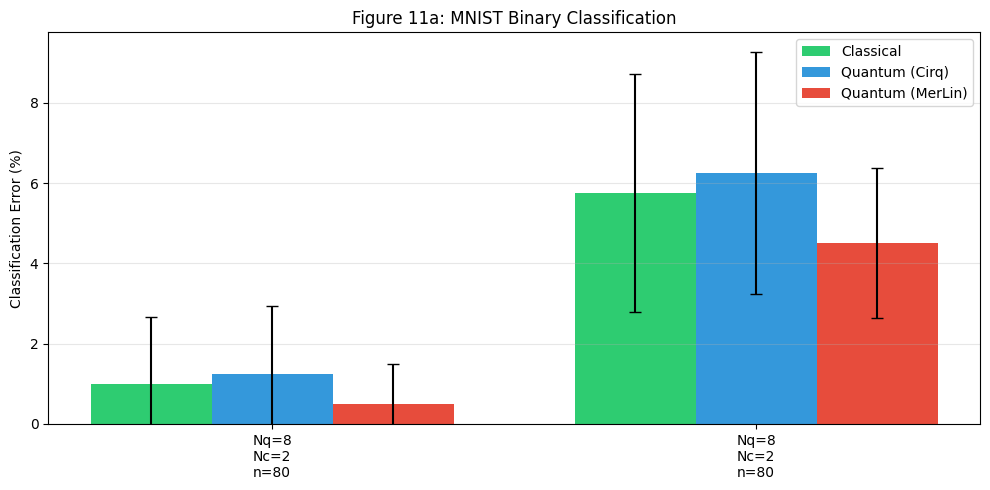

In [13]:
plot_error_bars(
    mnist_binary_results,
    "Figure 11a: MNIST Binary Classification",
    RESULTS_DIR / "fig11a_mnist_binary.png",
)
plt.show()

In [14]:
# 4-class classification
print("MNIST 4-class: digits 0-3")
mnist_4class_result = run_subset_experiment(
    X_mnist,
    y_mnist,
    classes=[0, 1, 2, 3],
    n_components=8,
    n_shots=1000,
    n_repeats=10,
    test_size=0.5,
    max_samples=160,
    run_dir=RESULTS_DIR,
)
print("  Classical: " + str(round(mnist_4class_result["c_acc_mean"] * 100, 1)) + "%")
print("  Cirq:      " + str(round(mnist_4class_result["acc_mean"] * 100, 1)) + "%")
print("  MerLin:    " + str(round(mnist_4class_result["ml_acc_mean"] * 100, 1)) + "%")

MNIST 4-class: digits 0-3
  Classical: 87.9%
  Cirq:      88.8%
  MerLin:    88.2%


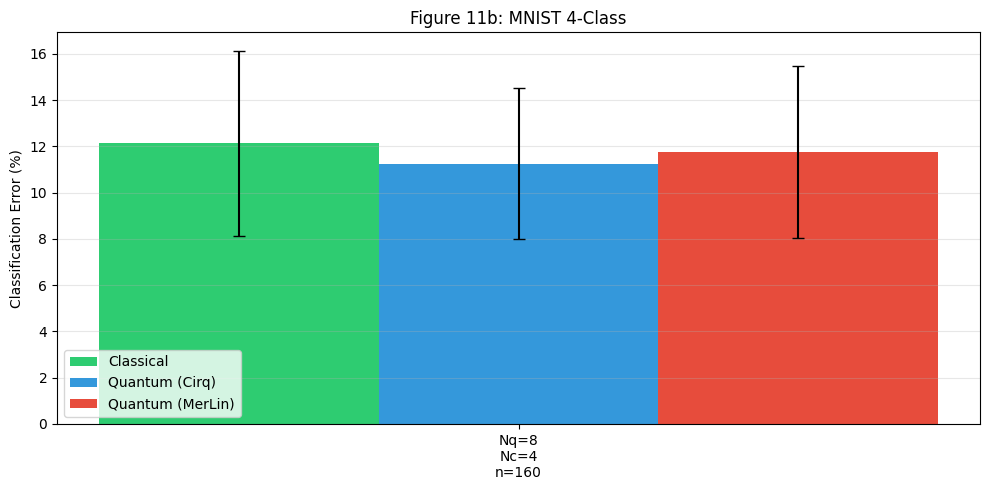

In [15]:
plot_error_bars(
    [mnist_4class_result],
    "Figure 11b: MNIST 4-Class",
    RESULTS_DIR / "fig11b_mnist_4class.png",
)
plt.show()

In [16]:
# 10-class (slow - disabled by default)
RUN_10CLASS = False

if RUN_10CLASS:
    print("MNIST 10-class: all digits (slow!)")
    mnist_10class_result = run_subset_experiment(
        X_mnist,
        y_mnist,
        classes=list(range(10)),
        n_components=8,
        n_shots=1000,
        n_repeats=10,
        test_size=0.5,
        max_samples=400,
        run_dir=RESULTS_DIR,
    )
    print(
        "  Classical: " + str(round(mnist_10class_result["c_acc_mean"] * 100, 1)) + "%"
    )
    print("  Cirq:      " + str(round(mnist_10class_result["acc_mean"] * 100, 1)) + "%")
    print(
        "  MerLin:    " + str(round(mnist_10class_result["ml_acc_mean"] * 100, 1)) + "%"
    )
    plot_error_bars(
        [mnist_10class_result],
        "Figure 11c: MNIST 10-Class",
        RESULTS_DIR / "fig11c_mnist_10class.png",
    )
    plt.show()
else:
    print("Skipping 10-class MNIST. Set RUN_10CLASS = True to run.")

Skipping 10-class MNIST. Set RUN_10CLASS = True to run.


---
## Summary

### Key Takeaways

1. Quantum data loaders use RBS gates in a tree structure to encode d-dimensional vectors in O(log d) depth

2. Inner product estimation measures the probability of a photon returning to its initial mode

3. Nearest centroid classification uses quantum distance estimation to find the closest class centroid

4. Ideal simulators (Cirq and MerLin) produce identical results - differences only arise from shot noise

### Observed Results

- Quantum classifiers match classical accuracy on well-separated clusters
- More shots (Ns) leads to better accuracy (reduced shot noise)
- Accuracy decreases with more classes (harder classification problem)

### Differences from Paper

| Aspect | Paper | This Reproduction |
|--------|-------|-------------------|
| Hardware | IonQ trapped ion | Ideal simulator |
| Noise | Real hardware noise | Shot noise only |
| Error mitigation | Post-selection | Not needed |

In [17]:
print("=" * 60)
print("COMPLETE RESULTS SUMMARY")
print("=" * 60)

print("")
print("--- Synthetic Data ---")
for r in synthetic_results:
    nc = len(r["classes"])
    nq = r["n_components"]
    c_acc = round(r["c_acc_mean"] * 100, 1)
    q_acc = round(r["acc_mean"] * 100, 1)
    m_acc = round(r["ml_acc_mean"] * 100, 1)
    print(
        "Nq="
        + str(nq)
        + ", Nc="
        + str(nc)
        + ": Classical="
        + str(c_acc)
        + "%, Cirq="
        + str(q_acc)
        + "%, MerLin="
        + str(m_acc)
        + "%"
    )

print("")
print("--- IRIS ---")
for r in iris_results:
    ns = r["n_shots"]
    c_acc = round(r["c_acc_mean"] * 100, 1)
    q_acc = round(r["acc_mean"] * 100, 1)
    m_acc = round(r["ml_acc_mean"] * 100, 1)
    print(
        "Ns="
        + str(ns)
        + ": Classical="
        + str(c_acc)
        + "%, Cirq="
        + str(q_acc)
        + "%, MerLin="
        + str(m_acc)
        + "%"
    )

print("")
print("--- MNIST ---")
for r in mnist_binary_results:
    c_acc = round(r["c_acc_mean"] * 100, 1)
    q_acc = round(r["acc_mean"] * 100, 1)
    m_acc = round(r["ml_acc_mean"] * 100, 1)
    print(
        str(r["classes"])
        + ": Classical="
        + str(c_acc)
        + "%, Cirq="
        + str(q_acc)
        + "%, MerLin="
        + str(m_acc)
        + "%"
    )

c_acc = round(mnist_4class_result["c_acc_mean"] * 100, 1)
q_acc = round(mnist_4class_result["acc_mean"] * 100, 1)
m_acc = round(mnist_4class_result["ml_acc_mean"] * 100, 1)
print(
    "4-class: Classical="
    + str(c_acc)
    + "%, Cirq="
    + str(q_acc)
    + "%, MerLin="
    + str(m_acc)
    + "%"
)

print("")
print("Figures saved to: " + str(RESULTS_DIR.absolute()))

COMPLETE RESULTS SUMMARY

--- Synthetic Data ---
Nq=4, Nc=2: Classical=100.0%, Cirq=100.0%, MerLin=99.0%
Nq=4, Nc=4: Classical=94.5%, Cirq=94.5%, MerLin=93.5%
Nq=8, Nc=2: Classical=85.0%, Cirq=79.0%, MerLin=79.0%
Nq=8, Nc=4: Classical=94.0%, Cirq=93.0%, MerLin=92.5%

--- IRIS ---
Ns=100: Classical=93.5%, Cirq=91.7%, MerLin=91.9%
Ns=500: Classical=93.5%, Cirq=91.5%, MerLin=91.9%
Ns=1000: Classical=93.5%, Cirq=92.4%, MerLin=92.0%

--- MNIST ---
[0, 1]: Classical=99.0%, Cirq=98.8%, MerLin=99.5%
[2, 7]: Classical=94.2%, Cirq=93.7%, MerLin=95.5%
4-class: Classical=87.9%, Cirq=88.8%, MerLin=88.2%

Figures saved to: C:\Users\BenjaminStott\PycharmProjects\pythonProject3\reproduced_papers\nearest_centroids_merlin\results
